In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load_data(df):
    
    N = df.shape[0]
    D = df.shape[1]-1
    
    bias = np.array([[1.]]*N)
    X = np.concatenate((bias, df.iloc[:, 1:]), axis=1)
    y = df.iloc[:, 0]
    
    df = df.drop(df.columns[0], axis=1)
    features = np.array(df.columns)
    
    return (X, y, features)

In [4]:
train_csv_path = 'logistic_regression_training_data.csv'
test_csv_path = 'logistic_regression_testing_data.csv'
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

In [5]:
df_train.head()

,label,num_preg,PGC,DBP,tricept,insulin,BMI,ped_func,age
0,1,0.470588,0.758794,0.639344,0.507937,0.35,0.639344,0.187020,0.250000
1,1,0.235294,0.663317,0.000000,0.000000,0.00,0.490313,0.095645,0.033333
2,0,0.058824,0.467337,0.459016,0.174603,0.00,0.335320,0.144748,0.016667
3,0,0.058824,0.547739,0.311475,0.285714,0.20,0.344262,0.140478,0.083333
4,1,0.176471,0.869347,0.688525,0.523810,0.79,0.532042,0.076857,0.016667


In [6]:
X_train, y_train, features = load_data(df_train)
X_test, y_test, _ = load_data(df_test)

X = {'train': X_train, 'test': X_test}
y = {'train': y_train, 'test': y_test}

In [7]:
features

array(['num_preg', 'PGC', 'DBP', 'tricept', 'insulin', 'BMI', 'ped_func',
       'age'], dtype=object)

## I. Logistic regression using SGD
### Logistic regression using Stochastic Gradient Descent (SGD) with below conditions

> a. Output class variable '$\texttt{label}$' : 0 - normal, 1 - diabetes  
> b. Assume that the data is randomly ordered   
> c. Learning rate = 0.8   
> d. Number of iterations = 100,000   
> e. Number of ensemble = 1000
> f. Loss function = average RSS (i.e., (1/N)*RSS where N is a total number of samples)   
> g. Initialize all weight values to 0  

- Plot average loss for every 100 iterations on train set (use loss function)
- Plot test error on test set (use loss function)

In [8]:
def sigmoid(x):
    
    ret = 1/(1+np.exp(-x))
    return ret


class LogisticRegressionSGD():
    
    def __init__(self, lr=0.8, iterations=100000, number_of_ensemble=1000):
        self.lr = lr
        self.iterations = iterations
        self.number_of_ensemble = number_of_ensemble
    
    
    def initialize_w(self, D):
        
        w = np.zeros(D)
        return w
        
        
    def predict(self, X, w):
        
        pred = (sigmoid(np.dot(X, w))>0.5).astype(int)
        return pred
    
    
    def get_train_sample(self, X, y, i):
        
        N = X.shape[0]
        D = X.shape[1]
        
        i = i%N
        X_ = X[i, :].reshape(1, -1)
        y_ = np.array([y[i]])
        
        return X_, y_
        
    
    def get_loss(self, X, y, w):
        
        error = np.sum(np.power(self.predict(X, w)-y, 2))/y.size
        return error
    
    
    def fit(self, X, y):

        D = X['train'].shape[1]
        
        self.avg_loss_over_itr = []
        self.test_error_over_itr = []
        self.w_ensemble = self.initialize_w(D)
        
        w = self.initialize_w(D)
        tot_loss = 0
        
        for i in range(self.iterations):
            
            X_, y_ = self.get_train_sample(X['train'], y['train'], i)
            tot_loss +=  self.get_loss(X_, y_, w)

            partial = X_*(sigmoid(np.dot(X_, w))-y_)
            w -= self.lr*partial.reshape(-1,)
            
            if (i + 1) % 100 == 0:
                avg_loss = tot_loss / (i + 1)
                test_error = self.get_loss(X['test'], y['test'], w)
                self.avg_loss_over_itr.append(avg_loss)
                self.test_error_over_itr.append(test_error)

            if self.iterations - (i+1) < self.number_of_ensemble:
                self.w_ensemble += w / self.number_of_ensemble

        return w
    
    
    def get_accuracy(self, X, y, w):
        
        accuracy = 100*np.sum((np.dot(X, w)>0.5).astype(int)==y)/y.size
        return accuracy

In [9]:
iterations = 100000
lr = 0.8
number_of_ensemble = 1000

In [10]:
logistic_regression = LogisticRegressionSGD(lr, iterations, number_of_ensemble)
w = logistic_regression.fit(X, y)

Text(0, 0.5, 'Average loss')

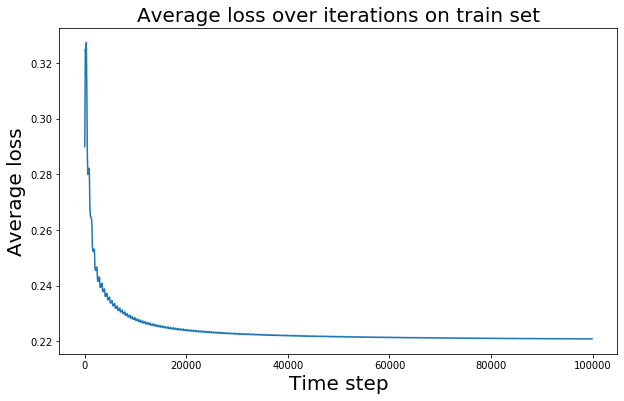

In [11]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(len(logistic_regression.avg_loss_over_itr)) * 100, logistic_regression.avg_loss_over_itr)
plt.title('Average loss over iterations on train set', fontsize=20)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('Average loss', fontsize=20)

Text(0, 0.5, 'Squared error')

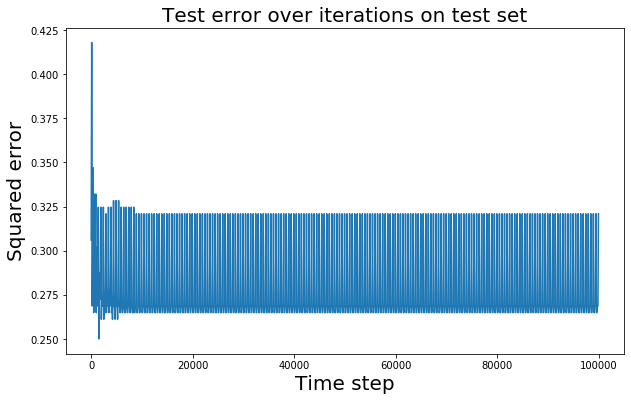

In [12]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(logistic_regression.test_error_over_itr)) * 100, logistic_regression.test_error_over_itr)
plt.title('Test error over iterations on test set', fontsize=20)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('Squared error', fontsize=20)

## II. Model evaluation and feature interpretations 
- Measure test accuracy using model after 100,000 iterations (accuracy = number of correct predictions / total number of predictions)
- Measure test accuracy using average model over the weights for the last 1000 iterations
- Estimate weights of following features, $\texttt{BMI}$, $\texttt{insulin}$, and $\texttt{PGC}$

In [13]:
def get_indices_of_fields(fields, features):
    
    sorter = np.argsort(features)
    indices = sorter[np.searchsorted(features, fields, sorter=sorter)]
    
    return indices

In [14]:
accuracy = logistic_regression.get_accuracy(X['test'], y['test'], w)
print(accuracy)

69.77611940298507


In [15]:
accuracy_ensemble = logistic_regression.get_accuracy(X['test'], y['test'], logistic_regression.w_ensemble)
print(accuracy_ensemble)

73.50746268656717


In [16]:
fields = np.array(['BMI', 'insulin', 'PGC'])
indices = get_indices_of_fields(fields, features)

In [17]:
logistic_regression.w_ensemble[indices]

array([-0.92481426, -0.03423808,  3.98788775])